## EDA - Dashboard

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 14:48:35 INFO SparkEnv: Registering MapOutputTracker
24/05/05 14:48:35 INFO SparkEnv: Registering BlockManagerMaster
24/05/05 14:48:35 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/05/05 14:48:35 INFO SparkEnv: Registering OutputCommitCoordinator


+----+---------------+
|hour|number_of_event|
+----+---------------+
|   0|         144303|
|   1|         140702|
|   2|         145879|
|   3|         150860|
|   4|         147184|
|   5|         119572|
|   6|          76972|
|   7|          43944|
|   8|          25309|
|   9|          17909|
|  10|          16408|
|  11|          20330|
|  12|          31486|
|  13|          51089|
|  14|          81823|
|  15|         129092|
|  16|         161784|
|  17|         179651|
|  18|         181200|
|  19|         183348|
+----+---------------+
only showing top 20 rows



DataFrame[hour: int, number_of_event: bigint]

root
 |-- hour: integer (nullable = true)
 |-- number_of_event: long (nullable = false)



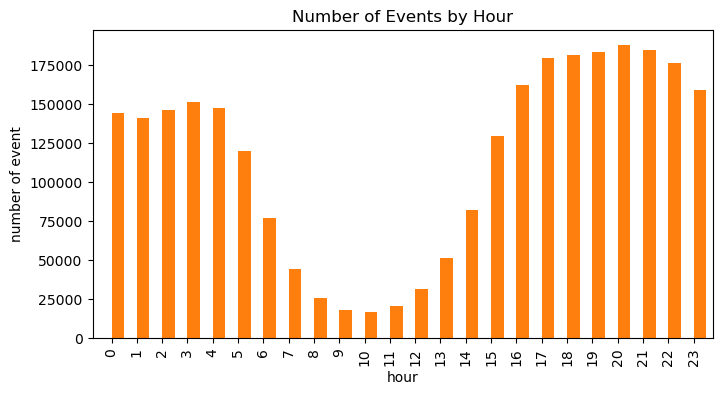

In [1]:
# Transform events table into events_dwh
# from_unixtime --> datetime (yyyy-MM-DD HH:mm:ss)
# Run in Cloud Jupyter Notebook

import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext

# credentials_location = '/root/.google/credentials/google-creds.json'

conf = SparkConf() \
    .setAppName('events') \
    .set("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .set("spark.hadoop.google.cloud.auth.service.account.enable", "true") 
#    .set("spark.hadoop.google.cloud.auth.service.account.json.keyfile", credentials_location)

spark = SparkSession.builder.config(conf=conf).getOrCreate()

project_id = "semar-de-project1"
dataset_id = "project1"
table_source = "events_dwh"

df = spark.read.format('bigquery') \
    .option("temporaryGcsBucket","dataproc-temp-asia-southeast2-212352110204-1oi7hped") \
    .option("project", project_id) \
    .option("dataset", dataset_id) \
    .load(table_source)
    
df.createOrReplaceTempView("temp_events")

df_number_event = spark.sql ("""
select hour (timestamp) as hour, count (*) as number_of_event
from temp_events
group by hour(timestamp)
order by 1
""")

df_number_event.show()
display(df_number_event)
df_number_event.printSchema()

select_hour_event = df_number_event \
  .select("hour", "number_Of_event") \
  .cache()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled'", "true")
pandas_hour_event = select_hour_event.toPandas()

pandas_hour_event.plot(kind='bar',figsize=(8,4), legend=False, xlabel='hour', ylabel='number of event', 
                       width=1, title="Number of Events by Hour");

spark.stop()